### Extension Project will address Bluebikes correlation with Bus performance.

With this, we will be using Bluebikes station and trip datasets along with previous data about bus given in Bus performance project document.

#### Subproblem 1: Worst on-time Performance Routes correlation with Bluebikes usage

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import os

In [126]:
folder_path = "../../data/"
blue_bikes_trips = pd.read_csv(f"{folder_path}/202201-bluebikes-tripdata.csv")
blue_bikes_stations = pd.read_csv(f"{folder_path}/current_bluebikes_stations.csv")
census_neighbourhood = pd.read_csv(f"{folder_path}/Census-Boston-Neighborhood.csv")
mbta_gtfs = pd.read_csv(f"{folder_path}/MBTA_Systemwide_GTFS_Map.csv")
mbta_reliability = pd.read_csv(f"{folder_path}/MBTA_Bus_Reliability.csv")
mbta_prediction_accuracy = pd.read_csv(f"{folder_path}/Bus_Prediction_Accuracy.csv")
mbta_bus_ridership = pd.read_csv(f"{folder_path}/MBTA_Bus_Ridership.csv")


C:\Users\sataa\AppData\Local\Temp\ipykernel_5364\437775067.py:8: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  mbta_bus_ridership = pd.read_csv(f"{folder_path}/MBTA_Bus_Ridership.csv")


In [117]:
def process_blue_bikes_trips(blue_bikes_trips):
	processed_blue_bikes_trips = blue_bikes_trips
	processed_blue_bikes_trips["tripduration"] = blue_bikes_trips["tripduration"] / 60
	return processed_blue_bikes_trips

processed_blue_bikes_trips = process_blue_bikes_trips(blue_bikes_trips)
processed_blue_bikes_trips.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,postal code
0,9.950000,2022-01-01 00:00:25.1660,2022-01-01 00:10:22.1920,178,MIT Pacific St at Purrington St,42.359573,-71.101295,74,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,4923,Subscriber,02139
1,6.850000,2022-01-01 00:00:40.4300,2022-01-01 00:07:32.1980,189,Kendall T,42.362428,-71.084955,178,MIT Pacific St at Purrington St,42.359573,-71.101295,3112,Subscriber,02139
2,7.933333,2022-01-01 00:00:54.8180,2022-01-01 00:08:51.6680,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,6901,Customer,02124
3,7.766667,2022-01-01 00:01:01.6080,2022-01-01 00:08:48.2350,94,Main St at Austin St,42.375603,-71.064608,356,Charlestown Navy Yard,42.374125,-71.054812,5214,Customer,02124
4,12.533333,2022-01-01 00:01:06.0520,2022-01-01 00:13:38.2300,19,Park Dr at Buswell St,42.347241,-71.105301,41,Packard's Corner - Commonwealth Ave at Brighto...,42.352261,-71.123831,2214,Subscriber,02215


In [118]:
# print(blue_bikes_stations.head())

def process_blue_bikes_stations(blue_bikes_stations, blue_bikes_trips):
	# Fixing first row as the column names
	new_column_names = blue_bikes_stations.iloc[0]  # Get the first row to use as column names
	blue_bikes_stations.columns = new_column_names  # Set new column names
	blue_bikes_stations = blue_bikes_stations.iloc[1:].reset_index(drop=True)

	# Extracting the unique start station names and IDs
	start_stations = blue_bikes_trips[['start station id', 'start station name']].drop_duplicates()
	start_stations = start_stations.rename(columns={'start station id': 'station_id', 'start station name': 'station_name'})

	# Extracting the unique end station names and IDs.
	end_stations = blue_bikes_trips[['end station id', 'end station name']].drop_duplicates()
	end_stations = end_stations.rename(columns={'end station id': 'station_id', 'end station name': 'station_name'})

	# Combining the start and end station information.
	combined_stations = pd.concat([start_stations, end_stations]).drop_duplicates().set_index('station_name')
	blue_bikes_stations['station_id'] = blue_bikes_stations['Name'].map(combined_stations['station_id'])
	blue_bikes_stations = blue_bikes_stations.dropna(subset = ["station_id"])
	return blue_bikes_stations

processed_blue_bikes_stations = process_blue_bikes_stations(blue_bikes_stations, processed_blue_bikes_trips)
processed_blue_bikes_stations.head()


,Number,Name,Latitude,Longitude,District,Public,Total docks,Deployment Year,station_id
0,K32015,1200 Beacon St,42.34414899,-71.11467361,Brookline,Yes,1,2021,452.0
1,W32006,160 Arsenal,42.36466403,-71.17569387,Watertown,Yes,11,2021,502.0
2,A32019,175 N Harvard St,42.36447457,-71.12840831,Boston,Yes,17,2014,149.0
3,S32035,191 Beacon St,42.38032335,-71.10878613,Somerville,Yes,19,2018,378.0
4,C32094,2 Hummingbird Lane at Olmsted Green,42.28887,-71.095003,Boston,Yes,17,2020,493.0


In [5]:
census_neighbourhood.head()

,tract20_nbhd,P0020001,P0020005,P0020006,P0020002,P002aapi,P002others,P0040001,P0040005,P0040006,...,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,H0010001,H0010002,H0010003,hhsize
0,field concept,Total:,White alone,Black or African American alone,Hispanic or Latino,"Asian, Native Hawaiian and Pacific Islander al...","Other Races or Multiple Races, all ages",Total:,White alone,Black or African American alone,...,Nursing facilities/Skilled-nursing facilities,Other institutional facilities,Noninstitutionalized population:,College/University student housing,Military quarters,Other noninstitutional facilities,Total:,Occupied,Vacant,household size
1,Allston,24904,12536,1326,3259,6271,1512,23140,11976,1184,...,0,0,3281,3214,0,67,10748,10027,721,2.156477511
2,Back Bay,18190,13065,690,1208,2410,817,17042,12349,641,...,269,0,1610,1487,0,123,11524,10006,1518,1.630121927
3,Beacon Hill,9336,7521,252,537,630,396,8603,6980,231,...,0,0,33,0,0,33,6037,5485,552,1.696080219
4,Brighton,52047,32694,2414,5376,8703,2860,47657,30752,2076,...,266,56,3796,3493,0,303,23653,22535,1118,2.126292434


In [6]:
mbta_gtfs.head()

def process_gtfs(MBTA_data):
	MBTA_data = MBTA_data[MBTA_data['Neighborhood'].notnull()]
	MBTA_data = MBTA_data[MBTA_data['Routes'] != '#N/A']
	MBTA_data = MBTA_data[MBTA_data['Routes'].notnull()]

	# Split routes column to separate routes
	MBTA_data['Routes'] = MBTA_data['Routes'].str.split('|')
	MBTA_data = MBTA_data.explode('Routes')
	df = MBTA_data[["stop_id", "stop_name", "stop_lat", "stop_lon", "Neighborhood", "Routes"]]

	return df

processed_mbta_gtfs = process_gtfs(mbta_gtfs)
processed_mbta_gtfs.head()


,stop_id,stop_name,stop_lat,stop_lon,Neighborhood,Routes
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,1
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,8
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,10
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,47
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,19


In [7]:
mbta_prediction_accuracy.head()

,weekly,mode,route_id,bin,arrival_departure,num_predictions,num_accurate_predictions,ObjectId
0,2021/08/13 04:00:00+00,bus,NaN,0-3 min,departure,293039,233562,1
1,2021/08/13 04:00:00+00,bus,NaN,3-6 min,departure,285817,229090,2
2,2021/08/13 04:00:00+00,bus,NaN,6-12 min,departure,561098,472923,3
3,2021/08/13 04:00:00+00,bus,NaN,12-30 min,departure,1594830,1405620,4
4,2021/08/20 04:00:00+00,bus,NaN,0-3 min,departure,285591,228653,5


In [8]:
mbta_reliability.head()

# Code taken from Base Question 2 code
def process_reliability(df):
	new_df = df[df["mode_type"]=="Bus"] # taking only buses
	new_df = new_df.dropna(subset=['otp_denominator', 'otp_numerator','cancelled_numerator']) # No NaN / Null
	new_df['ot_rate'] = new_df['otp_numerator']/new_df['otp_denominator']
	grouped_route = new_df.groupby('gtfs_route_id')
	grouped_rate = grouped_route['ot_rate'].mean().reset_index()
	rate_sorted = grouped_rate.sort_values(by='ot_rate', ascending=False)
	return rate_sorted


reliability_rate_sorted = process_reliability(mbta_reliability)

reliability_rate_sorted.head() # best ot_rate
reliability_rate_sorted.tail() # worst ot_rate


,gtfs_route_id,ot_rate
150,747,0.458202
106,459,0.429970
99,448,0.406302
100,449,0.402552
178,9703,0.320094


#### We have the best and worst on-time performance data extracted from base question 2 - Utilizes the MBTA Reliability Dataset:

Best 10:

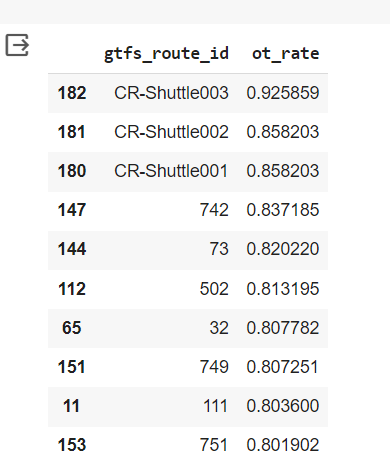

Worst 10:

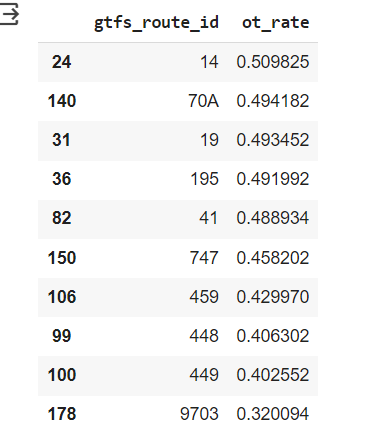



In [19]:
merged_data_on_routes = pd.merge(processed_mbta_gtfs, reliability_rate_sorted, left_on = "Routes", right_on = "gtfs_route_id")

print(merged_data_on_routes['gtfs_route_id'].isna().sum()) # checking no bus routes are not included in the relability dataset.
print(merged_data_on_routes['Routes'].isna().sum()) # checking no bus routes are not included in the GTFS dataset.

merged_data_on_routes.head()


0
0


,stop_id,stop_name,stop_lat,stop_lon,Neighborhood,Routes,gtfs_route_id,ot_rate
0,1,Washington St opp Ruggles St,42.330957,-71.082754,Roxbury,1,1,0.744301
1,10003,Albany St opp Randall St,42.331591,-71.076237,Roxbury,1,1,0.744301
2,10100,Albany St @ Randall St,42.331675,-71.076347,Roxbury,1,1,0.744301
3,10101,Melnea Cass Blvd @ Harrison Ave,42.332066,-71.079147,Roxbury,1,1,0.744301
4,10590,Massachusetts Ave @ Washington St,42.336621,-71.076956,South End,1,1,0.744301


In [168]:
# Group by 'Routes'
grouped_by_routes = merged_data_on_routes.groupby('Routes')

grouped_by_routes.head()

# # Aggregate 'ot_rate' for each route, then sort to find the worst 10
# # Assuming 'worst' means the highest values
worst_routes = grouped_by_routes['ot_rate'].mean().sort_values(ascending=True).head(10)

# # Print the worst 10 routes based on ot_rate
print(worst_routes.head())

Routes
9703    0.320094
449     0.402552
448     0.406302
459     0.429970
747     0.458202
Name: ot_rate, dtype: float64


In [169]:
worst_routes_loc = pd.merge(worst_routes, merged_data_on_routes, left_on = ["Routes", "ot_rate"], right_on = ["Routes", "ot_rate"])
worst_routes_loc.rename(columns={"Routes": "route"}, inplace=True)
worst_routes_loc.head(25) # rows are per stop, so showing more rows ensures the visibility of other routes here beyond route 9703
# print(worst_routes_loc.shape)


,route,ot_rate,stop_id,stop_name,stop_lat,stop_lon,Neighborhood,gtfs_route_id
0,9703,0.320094,1111,Cambridge St opp Hano St,42.353931,-71.136365,Allston,9703
1,9703,0.320094,1112,Cambridge St @ Harvard St,42.355641,-71.132361,Allston,9703
2,9703,0.320094,1113,Cambridge St @ Linden St,42.355943,-71.131448,Allston,9703
3,9703,0.320094,1114,Cambridge St @ N Harvard St,42.357758,-71.126505,Allston,9703
4,9703,0.320094,11388,Huntington Ave @ Belvidere St,42.345344,-71.082045,Back Bay,9703
5,9703,0.320094,1257,Tremont St @ Prentiss St,42.332930,-71.092638,Roxbury,9703
6,9703,0.320094,1258,Tremont St @ Roxbury Crossing Station,42.331311,-71.094831,Roxbury,9703
7,9703,0.320094,1260,Columbus Ave @ New Cedar St,42.328067,-71.097310,Roxbury,9703
8,9703,0.320094,1262,Columbus Ave @ Heath St,42.325028,-71.098483,Roxbury,9703
9,9703,0.320094,1784,Ruggles St @ Huntington Ave,42.337416,-71.095079,Mission Hill,9703


From here, we will be comparing locations of bus stations of the worst routes and the locations of bluebikes going along those routes. We will then see the average number of rides in that station. 

In [170]:
# This formula is used to take distances between locations (using longitude and latitude)

def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Earth radius in km
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance


# This formula will be used to test if bluebikes stations are within a 10 minute walk away from any of the worst route stops.
def no_more_than_x_mins(distance, x):
    max_walking_distance = x / 60  * 5 # assuming a walking speed of 5 km/h.
    return distance <= max_walking_distance

In [171]:
MAX_WALKING_DISTANCE = 10 # in minutes

close_blue_bikes_list = defaultdict(list)
# Comparing the locations:
for _, bus_stop in worst_routes_loc.iterrows():
    # Extract latitude and longitude for the bus stop
    bus_stop_lat, bus_stop_lon = float(bus_stop['stop_lat']), float(bus_stop['stop_lon'])

    # Iterate through each blue bike station
    for _, bike_station in processed_blue_bikes_stations.iterrows():
        # Extract latitude and longitude for the bike station
        bike_station_lat, bike_station_lon = float(bike_station['Latitude']), float(bike_station['Longitude'])

        # Calculate the distance between the bus stop and the bike station
        distance = haversine(bus_stop_lon, bus_stop_lat, bike_station_lon, bike_station_lat)

        if no_more_than_x_mins(distance, MAX_WALKING_DISTANCE):
            if (bike_station['station_id'] not in close_blue_bikes_list[bus_stop["route"]]): # taking only the distinct stops
                close_blue_bikes_list[bus_stop["route"]].append(bike_station["station_id"])

        

In [172]:
# Reverse the dictionary
bike_to_bus_station = {bike_station: bus_station for bus_station, bike_stations in close_blue_bikes_list.items() for bike_station in bike_stations}

# Filter the DataFrame
filtered_blue_bikes_stations = processed_blue_bikes_stations[processed_blue_bikes_stations['station_id'].isin(bike_to_bus_station.keys())]


# Add the new column for bus_station_id
filtered_blue_bikes_stations['route_id'] = filtered_blue_bikes_stations['station_id'].map(bike_to_bus_station)
	

C:\Users\sataa\AppData\Local\Temp\ipykernel_5364\2799738196.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_blue_bikes_stations['route_id'] = filtered_blue_bikes_stations['station_id'].map(bike_to_bus_station)


In [173]:
filtered_station_ids = set(filtered_blue_bikes_stations['station_id'])

# Filter the processed_blue_bikes_trips DataFrame
# Keep rows where either the start or end station is in the list of filtered station IDs
filtered_trips = processed_blue_bikes_trips[
    processed_blue_bikes_trips['start station id'].isin(filtered_station_ids) | 
    processed_blue_bikes_trips['end station id'].isin(filtered_station_ids)
]

print(filtered_trips.head())

    tripduration                 starttime                  stoptime  \
4      12.533333  2022-01-01 00:01:06.0520  2022-01-01 00:13:38.2300   
6      16.383333  2022-01-01 00:01:24.7490  2022-01-01 00:17:48.1850   
8      13.950000  2022-01-01 00:02:30.2650  2022-01-01 00:16:27.6270   
10     13.350000  2022-01-01 00:03:23.9650  2022-01-01 00:16:45.4150   
11     12.483333  2022-01-01 00:03:37.2630  2022-01-01 00:16:07.1390   

    start station id                           start station name  \
4                 19                        Park Dr at Buswell St   
6                 36  Copley Square - Dartmouth St at Boylston St   
8                 60  Charles Circle - Charles St at Cambridge St   
10                60  Charles Circle - Charles St at Cambridge St   
11                 4                  Tremont St at E Berkeley St   

    start station latitude  start station longitude  end station id  \
4                42.347241               -71.105301              41   
6         

In [174]:
avg_trip_duration_start = filtered_trips.groupby('start station id')['tripduration'].mean().reset_index()
avg_trip_duration_start.rename(columns={'start station id': 'station_id', 'tripduration': 'avg_start_duration'}, inplace=True)

# Calculate average trip duration for end stations
avg_trip_duration_end = filtered_trips.groupby('end station id')['tripduration'].mean().reset_index()
avg_trip_duration_end.rename(columns={'end station id': 'station_id', 'tripduration': 'avg_end_duration'}, inplace=True)

# Merge the two dataframes on station_id
merged_avg_durations = pd.merge(avg_trip_duration_start, avg_trip_duration_end, on='station_id', how='outer')

# Calculating the mean of the two averages, handling cases where one might be NaN
merged_avg_durations['avg_trip_duration'] = merged_avg_durations[['avg_start_duration', 'avg_end_duration']].mean(axis=1, skipna=True)

all_trip_averages = pd.merge(merged_avg_durations, filtered_blue_bikes_stations)
print(all_trip_averages[["station_id", "avg_trip_duration", "avg_start_duration", "avg_end_duration", "route_id"]])

     station_id  avg_trip_duration  avg_start_duration  avg_end_duration  \
0             3          17.033691           15.262563         18.804818   
1             4          13.714921           14.297755         13.132086   
2             8          26.393002           36.228563         16.557442   
3             9          13.660425           12.675271         14.645580   
4            10          12.328906           12.048364         12.609447   
..          ...                ...                 ...               ...   
119         538          14.845833           13.483333         16.208333   
120         544          11.534584           11.609878         11.459290   
121         547          98.564286           97.273810         99.854762   
122         548          27.911111           27.911111               NaN   
123         554          13.976831           14.347641         13.606021   

    route_id  
0         19  
1        701  
2       9703  
3        747  
4        747

In [192]:
trip_duration_start = filtered_trips.groupby('start station id')
# trip_duration_start.rename(columns={'start station id': 'station_id', 'tripduration': 'trip_duration'}, inplace=True)

# Calculate average trip duration for end stations
trip_duration_end = filtered_trips.groupby('end station id')
# trip_duration_end.rename(columns={'end station id': 'station_id', 'tripduration': 'trip_duration'}, inplace=True)

print(trip_duration_start.head(), trip_duration_end.head())


       tripduration                 starttime                  stoptime  \
4         12.533333  2022-01-01 00:01:06.0520  2022-01-01 00:13:38.2300   
6         16.383333  2022-01-01 00:01:24.7490  2022-01-01 00:17:48.1850   
8         13.950000  2022-01-01 00:02:30.2650  2022-01-01 00:16:27.6270   
10        13.350000  2022-01-01 00:03:23.9650  2022-01-01 00:16:45.4150   
11        12.483333  2022-01-01 00:03:37.2630  2022-01-01 00:16:07.1390   
...             ...                       ...                       ...   
75059     23.150000  2022-01-28 11:15:13.7100  2022-01-28 11:38:22.8430   
77193     38.716667  2022-01-28 20:07:52.7650  2022-01-28 20:46:36.4570   
77749     11.733333  2022-01-28 21:33:41.1780  2022-01-28 21:45:25.6760   
79611     52.766667  2022-01-29 04:27:02.8610  2022-01-29 05:19:49.4420   
81251     61.066667  2022-01-31 22:33:21.6430  2022-01-31 23:34:26.1770   

       start station id                           start station name  \
4                    19    

In [182]:
average_duration_by_route = all_trip_averages.groupby('route_id')['avg_trip_duration'].mean()
print(average_duration_by_route.head())

route_id
14     762.125907
19      55.925891
41      74.703294
459     31.483486
701     17.881840
Name: avg_trip_duration, dtype: float64


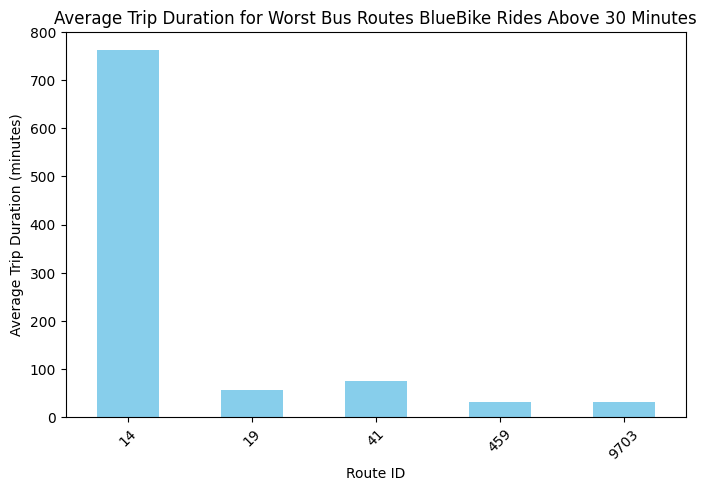

In [190]:
# Filter to include only routes with an average duration above 60 minutes
routes_above_30 = average_duration_by_route[average_duration_by_route > 30]

# Creating a bar graph for routes with average duration above 60 minutes
plt.figure(figsize=(8, 5))
routes_above_30.plot(kind='bar', color='skyblue')

plt.xlabel('Route ID')
plt.ylabel('Average Trip Duration (minutes)')
plt.title('Average Trip Duration for Worst Bus Routes BlueBike Rides Above 30 Minutes')
plt.xticks(rotation=45)

plt.show()

In [189]:
print(len(close_blue_bikes_list["14"]), len(close_blue_bikes_list["41"]))

29 21


Despite the similarity in number of bluebike stations close by those two stations 41, and 14, we see that the average biking duration for route 14 is much much higher. This may be an indication of either of two things: Either the bus route servicing is subpar in the area, or there may be an abundance of explorers there.

In [134]:
start_station_trip_count = blue_bikes_trips.groupby('start station id')["start station id"].count().reset_index(name='start_station_trip_count')
end_station_trip_count = blue_bikes_trips.groupby('end station id')["end station id"].count().reset_index(name='end_station_trip_count')

start_station_trip_count.rename(columns={'start station id': 'station_id'}, inplace=True)
end_station_trip_count.rename(columns={'end station id': 'station_id'}, inplace=True)

# Merge the two dataframes on 'station_id'
trip_counts = pd.merge(start_station_trip_count, end_station_trip_count)
trip_counts.columns = ['start_station_trip_count', 'end_station_trip_count']
trip_counts["difference"] = trip_counts["end_station_trip_count"] - trip_counts["start_station_trip_count"] # Negative means more stations that people pick up bikes from.
print(trip_counts.head())

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [131]:
# Reverse the dictionary
station_to_bus_route = {}
for route, stations in close_blue_bikes_list.items():
    for station in stations:
        if station not in station_to_bus_route:
            station_to_bus_route[station] = route


In [ ]:
trip_counts['route_id'] = trip_counts['station_id'].map(station_to_bus_route)
print(trip_counts.head())

(81449, 14)
   tripduration                 starttime                  stoptime  \
0      9.950000  2022-01-01 00:00:25.1660  2022-01-01 00:10:22.1920   
1      6.850000  2022-01-01 00:00:40.4300  2022-01-01 00:07:32.1980   
2      7.933333  2022-01-01 00:00:54.8180  2022-01-01 00:08:51.6680   
3      7.766667  2022-01-01 00:01:01.6080  2022-01-01 00:08:48.2350   
4     12.533333  2022-01-01 00:01:06.0520  2022-01-01 00:13:38.2300   

   start station id               start station name  start station latitude  \
0               178  MIT Pacific St at Purrington St               42.359573   
1               189                        Kendall T               42.362428   
2                94             Main St at Austin St               42.375603   
3                94             Main St at Austin St               42.375603   
4                19            Park Dr at Buswell St               42.347241   

   start station longitude  end station id  \
0               -71.101295        

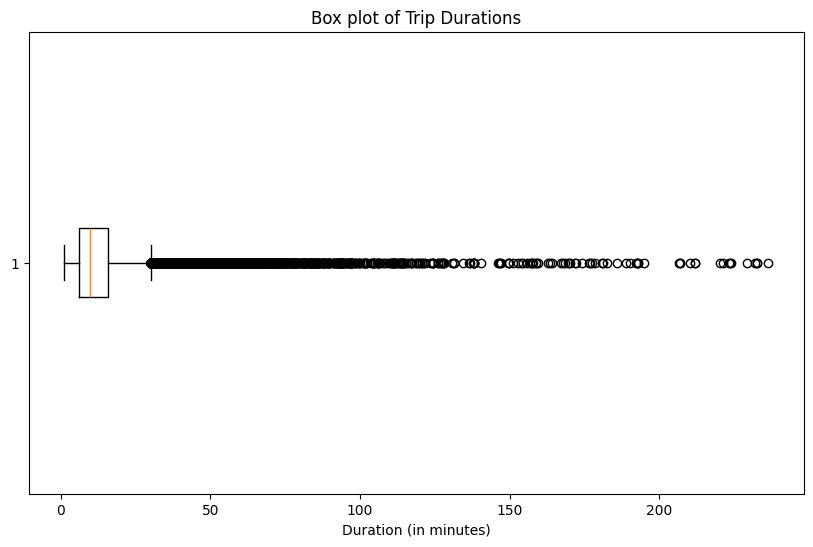

In [203]:
df = pd.DataFrame(processed_blue_bikes_trips)

df = df[df['tripduration'] <= 240]

print(processed_blue_bikes_trips.head())
# Create a box plot for the 'tripduration' column
plt.figure(figsize=(10, 6))
plt.boxplot(df['tripduration'], vert=False)  # 'vert=False' makes the box plot horizontal
plt.title('Box plot of Trip Durations')
plt.xlabel('Duration (in minutes)')
plt.show()